In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from haversine import haversine
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import MEstimateEncoder
from sklearn.feature_selection import mutual_info_regression


%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)

In [2]:
# Read in cleaned training and testing datasets

train_filepath = './datasets/cleaned_train_set.csv'
test_filepath = './datasets/cleaned_test_set.csv'

train_df = pd.read_csv(train_filepath)
test_df = pd.read_csv(test_filepath)

# Make copy to avoid changing the original datasets first
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

C:\Users\leagu\AppData\Local\Temp\ipykernel_5716\3048443952.py:6: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_filepath)
C:\Users\leagu\AppData\Local\Temp\ipykernel_5716\3048443952.py:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_filepath)


In [3]:
# Replace mid_storey values with Ordinal Encoding from 1-22

mid_storey_dict = {storey: idx+1 for idx, storey in enumerate(set(train_df_copy['mid_storey'].values))}

# Train copy
train_df_copy['mid_storey'] = train_df_copy['mid_storey'].map(lambda x: mid_storey_dict[x])

# Test copy
test_df_copy['mid_storey'] = test_df_copy['mid_storey'].map(lambda x: mid_storey_dict[x])


In [4]:
# One-Hot Encode flat_type

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Train copy
OH_flat_type_train = pd.DataFrame(OH_encoder.fit_transform(train_df[['flat_type']]))
OH_flat_type_train.columns = OH_encoder.get_feature_names_out()   # to put back encoded col names
train_df_copy = pd.concat([OH_flat_type_train, train_df_copy], axis=1)

# Test copy
OH_flat_type_test = pd.DataFrame(OH_encoder.transform(test_df[['flat_type']]))
OH_flat_type_test.columns = OH_encoder.get_feature_names_out()
test_df_copy = pd.concat([OH_flat_type_test, test_df_copy], axis=1)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
# One-Hot Encode flat_model

# Train copy
OH_flat_model_train = pd.DataFrame(OH_encoder.fit_transform(train_df[['flat_model']]))
OH_flat_model_train.columns = OH_encoder.get_feature_names_out()
train_df_copy = pd.concat([OH_flat_model_train, train_df_copy], axis=1)

# Test copy
OH_flat_model_test = pd.DataFrame(OH_encoder.transform(test_df[['flat_model']]))
OH_flat_model_test.columns = OH_encoder.get_feature_names_out()
test_df_copy = pd.concat([OH_flat_model_test, test_df_copy], axis=1)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
# Add a feature that averages the distance to all Nearest amenities

# Train copy
train_df_copy['average_dist_amenities'] = 0.25*(train_df_copy['mrt_nearest_distance']+train_df_copy['hawker_nearest_distance']+train_df_copy['bus_stop_nearest_distance']+train_df_copy['pri_sch_nearest_distance'])

# Test copy
test_df_copy['average_dist_amenities'] = 0.25*(test_df_copy['mrt_nearest_distance']+test_df_copy['hawker_nearest_distance']+test_df_copy['bus_stop_nearest_distance']+test_df_copy['pri_sch_nearest_distance'])

In [7]:
# Add a total count feature of all convenience amenities within 1km

# Train copy
train_df_copy['count_of_convenience_within_1km'] =  (train_df_copy['market_hawker']+
                                            train_df_copy['multistorey_carpark']+
                                            train_df_copy['precinct_pavilion']+
                                            train_df_copy['mall_within_1km']+
                                            train_df_copy['hawker_within_1km']+
                                            train_df_copy['bus_interchange']+
                                            train_df_copy['mrt_interchange'])



# Test copy
test_df_copy['count_of_convenience_within_1km'] =  (test_df_copy['market_hawker']+
                                            test_df_copy['multistorey_carpark']+
                                            test_df_copy['precinct_pavilion']+
                                            test_df_copy['mall_within_1km']+
                                            test_df_copy['hawker_within_1km']+
                                            test_df_copy['bus_interchange']+
                                            test_df_copy['mrt_interchange'])

In [8]:
# Add feature geodistance (in meters) to City Hall

# Train copy
city_hall = (1.2931576, 103.852073)
train_df_copy['house_coord'] = tuple(zip(train_df.latitude, train_df.longitude))
train_df_copy['distance_to_cityhall'] = train_df_copy['house_coord'].map(lambda hse: haversine(hse, city_hall, unit='m'))


# Test copy
test_df_copy['house_coord'] = tuple(zip(test_df.latitude, test_df.longitude))
test_df_copy['distance_to_cityhall'] = test_df_copy['house_coord'].map(lambda hse: haversine(hse, city_hall, unit='m'))

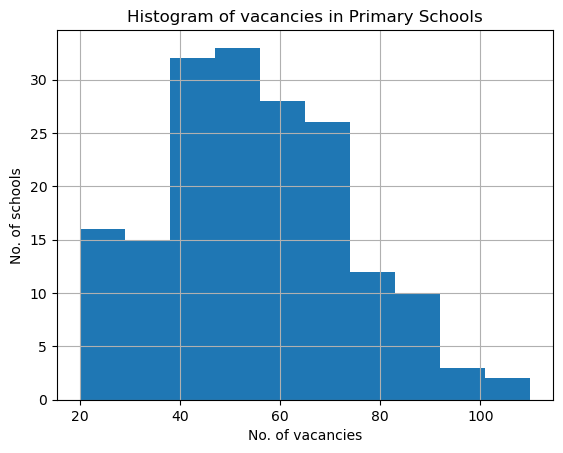

In [9]:
# Ranking Primary Schools by Vacancies

pri_sch_rankings = train_df_copy[['pri_sch_name','vacancy']].groupby('pri_sch_name')['vacancy'].mean().sort_values()
pri_sch_rankings.hist()
plt.title("Histogram of vacancies in Primary Schools")
plt.xlabel('No. of vacancies')
plt.ylabel('No. of schools')

# Rank pri schools by vacancies
# 20-40: Rank 1
# 40-60: Rank 2
# 60-above: Rank 3

def rank_pri_sch(sch_vacancies):
    if sch_vacancies < 40:
        return 1
    elif sch_vacancies < 60:
        return 2
    else:
        return 3

train_df_copy['pri_sch_rank'] = train_df_copy['vacancy'].map(lambda vacancy: rank_pri_sch(vacancy))
test_df_copy['pri_sch_rank'] = test_df_copy['vacancy'].map(lambda vacancy: rank_pri_sch(vacancy))


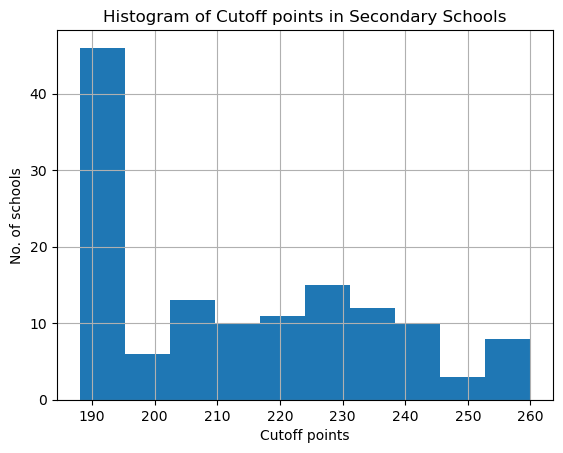

In [10]:
# Ranking Secondary Schools by Cutoff

sec_sch_rankings = train_df_copy[['sec_sch_name','cutoff_point']].groupby('sec_sch_name')['cutoff_point'].mean().sort_values()
sec_sch_rankings.hist()
plt.title("Histogram of Cutoff points in Secondary Schools")
plt.xlabel('Cutoff points')
plt.ylabel('No. of schools')

# Rank sec schools by cutoff
# >240: Rank 1
# 220-240: Rank 2
# <220: Rank 3

def rank_sec_sch(cutoff):
    if cutoff > 240:
        return 1
    elif cutoff > 220:
        return 2
    else:
        return 3

train_df_copy['sec_sch_rank'] = train_df_copy['cutoff_point'].map(lambda cutoff: rank_sec_sch(cutoff))
test_df_copy['sec_sch_rank'] = test_df_copy['cutoff_point'].map(lambda cutoff: rank_sec_sch(cutoff))

In [11]:
# Create Interaction terms between School Ranking and its Distance

# Train copy
train_df_copy['pri_sch_rank_X_distance'] = train_df_copy['pri_sch_rank']*train_df_copy['pri_sch_nearest_distance']
train_df_copy['sec_sch_rank_X_distance'] = train_df_copy['sec_sch_rank']*train_df_copy['sec_sch_nearest_dist']

# Test copy
test_df_copy['pri_sch_rank_X_distance'] = test_df_copy['pri_sch_rank']*test_df_copy['pri_sch_nearest_distance']
test_df_copy['sec_sch_rank_X_distance'] = test_df_copy['sec_sch_rank']*test_df_copy['sec_sch_nearest_dist']

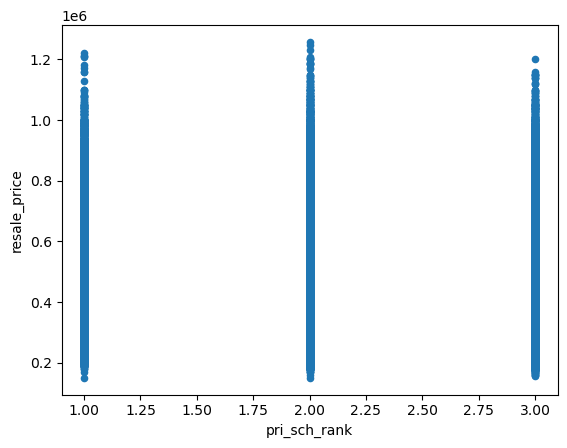

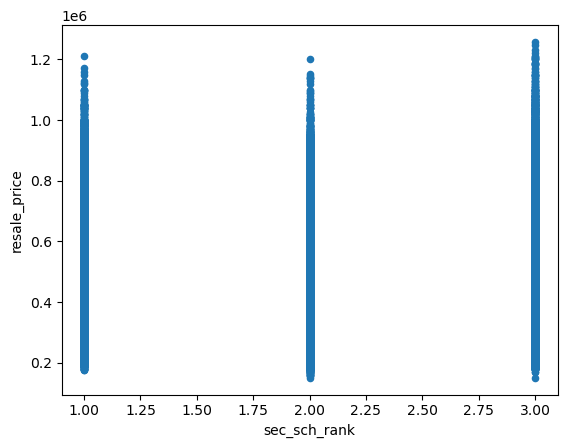

In [12]:
# Seems like there is no predictive value in both pri and sec sch rankings!

train_df_copy.plot(kind='scatter', x='pri_sch_rank', y='resale_price')   
train_df_copy.plot(kind='scatter', x='sec_sch_rank', y='resale_price');   

In [13]:
# Target-Encoding of 'postal', 'full_flat_type', 'planning_area', 'bus_stop_name'

X_encode = train_df_copy.sample(frac=0.25, random_state=0)  # we are apportioning out 25% of training data for target-encoding, this frac will no longer be used for linearReg fitting later
y_encode = X_encode.pop('resale_price')

X_pretrain = train_df_copy.drop(X_encode.index)
y_train = X_pretrain.pop('resale_price')

encoder = MEstimateEncoder(cols=['postal', 'full_flat_type', 'planning_area', 'bus_stop_name'], m=3.0)  # input the feature you want to target-encode

encoder.fit(X_encode, y_encode)


# Target-encode Train data
X_train_target_encoded = encoder.transform(X_pretrain, y_train)  # Note: 'resale_price' is no longer in X_train_target_encoded

# Target-encode Test data
X_test_target_encoded = encoder.transform(test_df_copy)


### Let's see how informative target encoding of those features have become...

C:\Users\leagu\AppData\Local\Temp\ipykernel_3636\3307038779.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_train, kde=False, norm_hist=True)


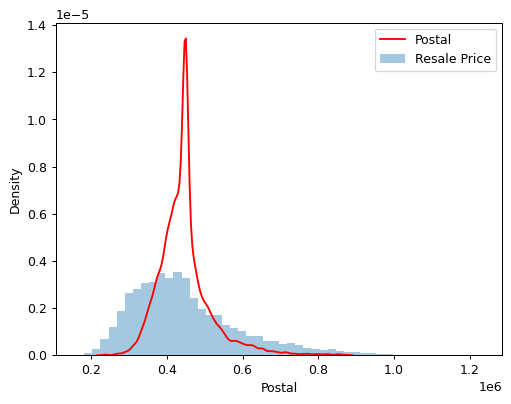

In [14]:
# The distribution of Postal roughly follows the distribution of resale_price which target-encoding was able to capture

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train_target_encoded.postal, color='r', ax=ax)    # we have encoded Zipcode col
ax.set_xlabel ("Postal")
ax.legend(labels=['Postal', 'Resale Price']);

C:\Users\leagu\AppData\Local\Temp\ipykernel_19156\3552212675.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_train, kde=False, norm_hist=True)


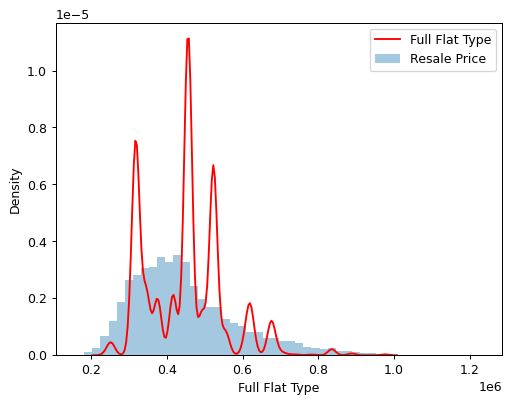

In [23]:
# Full_flat_type is very noisy

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train_target_encoded.full_flat_type, color='r', ax=ax)    # we have encoded Zipcode col
ax.set_xlabel ("Full Flat Type")
ax.legend(labels=['Full Flat Type', 'Resale Price']);

C:\Users\leagu\AppData\Local\Temp\ipykernel_19156\1845487339.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_train, kde=False, norm_hist=True)


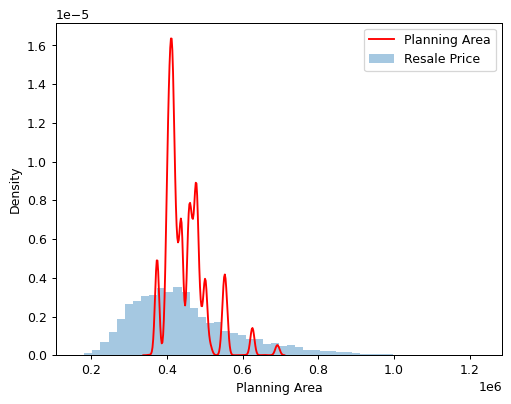

In [24]:
# Planning_Area is also quite noisy as well but there is some predictive potential

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train_target_encoded.planning_area, color='r', ax=ax)    # we have encoded Zipcode col
ax.set_xlabel ("Planning Area")
ax.legend(labels=['Planning Area', 'Resale Price']);

C:\Users\leagu\AppData\Local\Temp\ipykernel_19156\3810197105.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_train, kde=False, norm_hist=True)


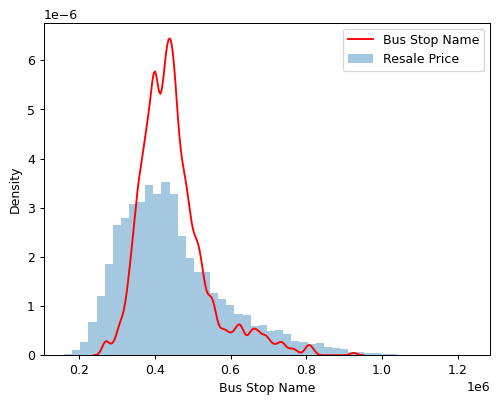

In [25]:
# Bus_Stop_Name is very strong! Perfect-matching distribution

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train_target_encoded.bus_stop_name, color='r', ax=ax)    # we have encoded Zipcode col
ax.set_xlabel ("Bus Stop Name")
ax.legend(labels=['Bus Stop Name', 'Resale Price']);

In [29]:
# Check to see if all potentially needed features have been correctly encoded in training data

print(X_train_target_encoded.shape)
print(X_train_target_encoded.head())

(112354, 111)
   flat_model_2-room  flat_model_Adjoined flat  flat_model_Apartment  \
1                0.0                       0.0                   0.0   
2                0.0                       0.0                   1.0   
3                0.0                       0.0                   0.0   
4                0.0                       0.0                   0.0   
5                0.0                       0.0                   0.0   

   flat_model_DBSS  flat_model_Improved  flat_model_Improved-Maisonette  \
1              0.0                  1.0                             0.0   
2              0.0                  0.0                             0.0   
3              0.0                  0.0                             0.0   
4              0.0                  0.0                             0.0   
5              0.0                  1.0                             0.0   

   flat_model_Maisonette  flat_model_Model A  flat_model_Model A-Maisonette  \
1                    0.

In [30]:
# Check to see if all potentially needed features have been correctly encoded in testing data

print(X_test_target_encoded.shape)
print(X_test_target_encoded.head())

(16737, 111)
   flat_model_2-room  flat_model_Adjoined flat  flat_model_Apartment  \
0                0.0                       0.0                   0.0   
1                0.0                       0.0                   0.0   
2                0.0                       0.0                   0.0   
3                0.0                       0.0                   0.0   
4                0.0                       0.0                   0.0   

   flat_model_DBSS  flat_model_Improved  flat_model_Improved-Maisonette  \
0              0.0                  0.0                             0.0   
1              0.0                  0.0                             0.0   
2              0.0                  0.0                             0.0   
3              0.0                  0.0                             0.0   
4              0.0                  0.0                             0.0   

   flat_model_Maisonette  flat_model_Model A  flat_model_Model A-Maisonette  \
0                    0.0

In [34]:
# Save Encoded data to csv

X_train_target_encoded.to_csv('./datasets/encoded_X_train.csv', index=False)
X_test_target_encoded.to_csv('./datasets/encoded_X_test.csv', index=False)
y_train.to_csv('./datasets/y_train.csv', index=False)    # this is the resale_price which was 'popped' out of X_train_target_encoded earlier